# PyTorch Demo Script
On how to **build your own basic PyTorch layers** for a Multi-Layer Perceptron (MLP) and how to **train that network**.

In [ ]:
""" 
Stefan Schmohl, Dominik Laupheimer, 
Institute for Photogrammetry, 
University of Stuttgart, 2022
"""

import torch
import matplotlib.pyplot as plt

## Setting-Up Artifical Training Data
The dataset contains `n_p` samples, each represented by `n_c` **input features / channels**. We store all of them in a single 2D tensor of dimension `n_c` x `n_p` (aka each column represents one data point).

Each sample has a single **ground truth** value (for regression). For this demo, we simple use random values.    

We can transfer pytorch tensors from CPU / RAM to **GPU** / GPU memory (aka VRAM) via `device='cuda'` or `.cuda()` (reversly with `'cpu'`). 
Enable GPU support via  
`-> Bearbeiten -> Notebook-Einstellungen -> Hardwarebeschleuniger: GPU` 
or  
`Laufzeit -> Laufzeittyp ändern -> Hardwarebeschleuniger: GPU` 




In [ ]:
n_p = 5000   # number of data points
n_c = 40     # number of input channels

data = torch.rand((n_c, n_p), device='cuda') 
gt   = torch.rand((n_p, )).cuda()

print(data)
print(gt)
print(data.shape)
print(gt.shape)

tensor([[0.7388, 0.2669, 0.8927,  ..., 0.3417, 0.3292, 0.2211],
        [0.3768, 0.9687, 0.7263,  ..., 0.3214, 0.7069, 0.6824],
        [0.6771, 0.9038, 0.7120,  ..., 0.8786, 0.6621, 0.1675],
        ...,
        [0.3373, 0.4751, 0.6757,  ..., 0.1424, 0.0782, 0.8860],
        [0.7877, 0.2143, 0.3260,  ..., 0.0790, 0.2455, 0.0682],
        [0.3028, 0.9251, 0.9830,  ..., 0.9636, 0.5269, 0.4562]],
       device='cuda:0')
tensor([0.4069, 0.6111, 0.4952,  ..., 0.9700, 0.6581, 0.8865], device='cuda:0')
torch.Size([40, 5000])
torch.Size([5000])


## Defining Fully-Conntected Layer and ReLU
For the purpose of this demo, we define our own fully-connected layers. The **fully connected layers (FC)** (`torch.nn.Linear`) can be implemented through a simple matrix multiplication of the layer's input with the layer's weight matrix. We initialize the weights randomly around zero (zero-centering).

We tell PyTorch to record the **gradient function** (`requires_grad=True`) for this weight matrix, which will be used during backpropagation (True by default).

As activation function, we use a **Rectified Linear Unit (ReLU)** (`torch.nn.ReLU`). 

We have to define the **forward pass** only, since PyTorch's autograd will take care about the **backward pass**.  

In [ ]:
class FC(torch.nn.Module):
  def __init__(self, cin, cout):
    super(FC, self).__init__()
    self.weights = torch.nn.Parameter(torch.rand((cout, cin)) -0.5, requires_grad=True)

  def forward(self, input):
    return torch.matmul(self.weights, input)

  # def backward(self, gradient):
    # return torch.matmul(self.weights.transpose, gradient)
    # (correct in theory, but does not really work like that in pytorch ;))


class ReLU(torch.nn.Module):
  def __init__(self):
    super(ReLU, self).__init__()

  def forward(self, input):
    output = input.clone()
    output[output<0] = 0
    return output

## Defining the Loss Function
Quadratic **L2-Loss** averaged over all samples (aka Mean Square Error, see `torch.nn.MSELoss`).

In [ ]:
class L2Loss(torch.nn.Module):
  def __init__(self):
    super(L2Loss, self).__init__()

  def forward(self, prediction, gt):
    return torch.mean(torch.pow(prediction - gt, 2))   # MSE

## Defining the Network (MLP)
A simple **Multi-Layer Perceptron (MLP)** with one hidden layer (i.e., the second layer is the output layer):  
Input layer neurons = input channels.  
Number of output neurons = 1 (one regression value per sample).

In [ ]:
class MLP(torch.nn.Module):

  def __init__(self, n_c):
    super(MLP, self).__init__()
    n_h = n_c // 2  # number of hidden neurons
    self.FC1 = FC(n_c, n_h)
    self.FC2 = FC(n_h, 1)
    # Alternatively:
    # self.Layers = torch.nn.Sequential(FC(n_c, n_h), ReLU(), FC(n_h, 1))

  def forward(self, input):
    x = self.FC1(input)
    a = ReLU()(x)
    y = self.FC2(a)
    # Alternatively (in accordance with alternative version in __init__())
    # y = self.Layers(input)
    return y.squeeze()  # 2D => 1D (because only one output value per sample)

## Training
After initializing the network on memory (and optionally moving it to GPU), you can pass its parameters (weights) to the optimizer (**Stochastic Gradient Descent (SGD)**. The **Learning Rate (LR)** is one of the most important hyperparameters!  

We train the network over **100 Epochs**.  
The whole dataset is passed through the network at once => **parallelism**! This is possible, as  
a) the number of samples `n_p` is the second dimension of the data matrix `data`, so the matrix multiplication results in one output per data point (e.g., for the first layer: `outputs[dim: n_h x n_p] = weights[dim: n_h x n_c] * data[dim:n_c x n_p]`) and  
b) the data fits into memory. In practice, we would divide the data into smaller so-called mini-batches (=> iterations per training epoch).



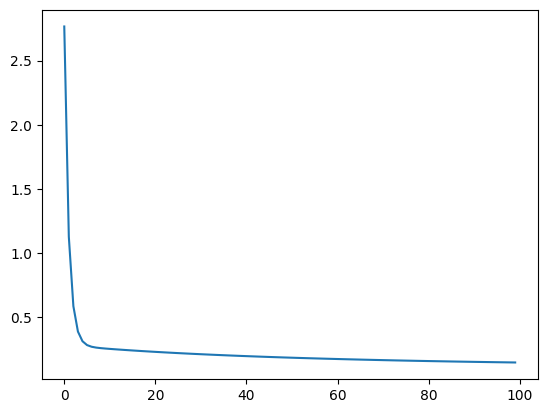

CPU times: user 239 ms, sys: 109 ms, total: 347 ms
Wall time: 247 ms


In [ ]:
%%time

net = MLP(n_c).to(data.device)
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)

log = []
for i in range(100):
  optimizer.zero_grad()         # Set gradient buffers to zero to prevent accumulations
  outputs = net(data)           # Forward pass
  loss = L2Loss()(outputs, gt)  # Calculate the loss; alternatively: loss = L2Loss().forward(outputs, gt)
  loss.backward()               # Backpropagation: compute gradients
  optimizer.step()              # Parameter update
  #print("loss:", loss)
  log.append(loss.item())

plt.plot(log)
plt.show()